### Control Parameters 

In [1]:
import datetime
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load

In [2]:
## parameters
exp_index = [
            'coil',
            'coil_double',
            'coil_reverse',
            'coil_reverse_double',
            'coil_down',
            'coil_reverse_down',
            'square',
            'square_double',
            'lines',
            'lines_reverse',
            'manual',
#             'manual_wind',
#             'coil_reverse_double_wind',
#             'coil_double_wind',
#             'squre_double_wind'
            ]

data_folder_path = './blimpSim/data/behaviour_policy'
results_path = './blimpSim/results'

bool_convert_rosbag2csv = False

    # *******************************************

## Load csv files
class Msg_structure:
    def __init__(self, name=None, feature_list=None, feature_rename_list=None):
        self.name = name
        self.feature_list = feature_list
        self.feature_rename_list = feature_rename_list


position_msg = Msg_structure(name = 'ground_truth-position', 
                             feature_list =  ['Time','point.x','point.y','point.z'], 
                             feature_rename_list = ['Time', 'positoin.x', 'position.y', 'position.z'])
imu_msg = Msg_structure(name = 'ground_truth-imu',
                        feature_list = ['Time','orientation.x','orientation.y','orientation.z','orientation.w',
                                        'angular_velocity.x','angular_velocity.y','angular_velocity.z',
                                        'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z'],
                        feature_rename_list = ['Time', 'imu.orientation.x','imu.orientation.y','imu.orientation.z','imu.orientation.w',
                                               'imu.angular_velocity.x','imu.angular_velocity.y','imu.angular_velocity.z',
                                               'imu.linear_acceleration.x','imu.linear_acceleration.y','imu.linear_acceleration.z'])
tail_imu_msg = Msg_structure(name = 'tail-imu',
                            feature_list = ['Time','orientation.x','orientation.y','orientation.z','orientation.w',
                                            'angular_velocity.x','angular_velocity.y','angular_velocity.z',
                                            'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z'],
                            feature_rename_list = ['Time', 'tail_imu.orientation.x','tail_imu.orientation.y','tail_imu.orientation.z','tail_imu.orientation.w',
                                                   'tail_imu.angular_velocity.x','tail_imu.angular_velocity.y','tail_imu.angular_velocity.z',
                                                   'tail_imu.linear_acceleration.x','tail_imu.linear_acceleration.y','tail_imu.linear_acceleration.z'])
tail_position_msg = Msg_structure(name = 'tail-position', 
                                 feature_list =  ['Time','point.x','point.y','point.z'], 
                                 feature_rename_list = ['Time', 'tail.positoin.x', 'tail.position.y', 'tail.position.z'])

speed_msg = Msg_structure(name = 'ground_speed', 
                          feature_list = ['Time',
                              'twist.linear.x','twist.linear.y','twist.linear.z'], 
                          feature_rename_list = ['Time',
                              'velocity.linear.x','velocity.linear.y','velocity.linear.z']
                         )

autopilotInfo_msg = Msg_structure(name = 'AutopilotInfo',
                              feature_list = ['Time','VelocityDesired.x','VelocityDesired.y','VelocityDesired.z'],
                              feature_rename_list = ['Time','target.velocity.x','target.velocity.y','target.velocity.z']
                             )                                        
                             
obs_msg = [
#     position_msg,
    imu_msg,
#     tail_imu_msg,
#     tail_position_msg,
    speed_msg,
    autopilotInfo_msg
]

    # *******************************************

actuator_msg = Msg_structure(name = 'GCSACTUATORS',
                            feature_list = ['Time', 'data.data'],
                            feature_rename_list = ['Time', 'm2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3'])

act_msg = [actuator_msg]

all_msg = obs_msg + act_msg

    # *******************************************

pseudo_target_distribution_const = 0.2
pseudo_target_min = np.array([-5.5, -5.5, -1.2])
pseudo_target_max = np.array([5.5, 5.5, 1.2])
pseudo_target_name_list = autopilotInfo_msg.feature_rename_list
pseudo_target_features_num = len(pseudo_target_name_list)-1

num_transitions = 2
assert num_transitions>=2, 'num_transitions should be greater than 2'

obs_feature_list =  [msg.feature_rename_list for msg in obs_msg ]
act_feature_list =  [msg.feature_rename_list for msg in act_msg ]

time_feature_name = 'Time'
purge_feature_list=[]
purge_feature_list.append(time_feature_name)

## Data processing
act_filter_feature = ['m2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3']
train_test_split_ratio = (0.99,0.01)
act_scale_bnd = {'act_max':2000,
                 'act_min':1000,
                 'scaled_act_max':1,
                 'scaled_act_min':-1}

bool_addNoise = True
num_noise_df = 5
noise_level = 0.05

bool_round = False
rounding_factor = 3

## Define Reward Function
target_feature_list = ['target.velocity.x', 'target.velocity.y', 'target.velocity.z'] 
xy_target_feature_list = ['target.velocity.x', 'target.velocity.y'] 
xy_cost_feature_list = ['velocity.linear.x','velocity.linear.y']
z_target_feature_list = ['target.velocity.z'] 
z_cost_feature_list = ['velocity.linear.z']
actCost_feature_list = ['m0','m1','m2']
actChangeCost_feature_list = ['m0','m1','m2','stick','tfin','bfin','lfin','rfin']

weight_next_obs = 1
weight_prev_obs = 0 * 1/(num_transitions-1)
weight_prev_act = 0 * 1/(num_transitions-1)
weight_prev_actChange = 0 * 1/(num_transitions-1)
reward_weights = (weight_next_obs, weight_prev_obs, weight_prev_act, weight_prev_actChange) 

weight_xy_obs = 0
weigth_z_obs = 1
obs_reward_weights = (weight_xy_obs,weigth_z_obs)

## Create parameter dics
params = {
    "exp_index":exp_index,
    "data_folder_path":data_folder_path,
    "results_path":results_path,
    "bool_convert_rosbag2csv":bool_convert_rosbag2csv,
    
    "all_msg":all_msg,
    "obs_msg":obs_msg,    
    "act_msg":act_msg,

    "pseudo_target_name_list":pseudo_target_name_list,
    "pseudo_target_distribution_const":pseudo_target_distribution_const,
    "pseudo_target_features_num":pseudo_target_features_num,
    "pseudo_target_min":pseudo_target_min,
    "pseudo_target_max":pseudo_target_max,
    
    "num_transitions":num_transitions,
    "target_feature_list":target_feature_list,
    "xy_target_feature_list":xy_target_feature_list,
    "z_target_feature_list":z_target_feature_list,
    "obs_feature_list":obs_feature_list,
    "act_feature_list":act_feature_list,
    "time_feature_name":time_feature_name,
    "purge_feature_list":purge_feature_list,
    
    "act_filter_feature":act_filter_feature,
    "train_test_split_ratio":train_test_split_ratio,
    'act_scale_bnd':act_scale_bnd,
    "bool_addNoise":bool_addNoise,
    "num_noise_df":num_noise_df,
    "noise_level":noise_level,
    "bool_round":bool_round,
    "rounding_factor":rounding_factor,
    
    "xy_cost_feature_list":xy_cost_feature_list,
    "z_cost_feature_list":z_cost_feature_list,
    "actCost_feature_list":actCost_feature_list,
    "actChangeCost_feature_list":actChangeCost_feature_list,
    "reward_weights":reward_weights,
    "obs_reward_weights":obs_reward_weights,
    
}

### Convert rosbag to csv

In [3]:
if params["bool_convert_rosbag2csv"]:    
    import bagpy
    from bagpy import bagreader
    
    class ConvertBag2csv: 
        def __init__(self):
            pass

        def rosbag2csv(self,rosbag_path):
            b = bagreader(rosbag_path)
            csvfiles = []
            for t in b.topics:
                data = b.message_by_topic(t)
                csvfiles.append(data)

        def convert_rosbag2csv(self,directory):
            for root,dirs,files in os.walk(directory):
                for file in files:
                    if file.endswith(".bag"):
                        path = os.path.join(root,file)
                        self.rosbag2csv(path)
                        print(f'bag: {file} convert to csv')
        
    print(f'data_folder_path: {data_folder_path}')
    clsConvertBag2csv = ConvertBag2csv()
    
    print(f'----------Start Converting Rosbag to CSV files----------')
    clsConvertBag2csv.convert_rosbag2csv(data_folder_path)
    print(f'----------Finish Convert----------')

### Load data from csv files

In [4]:
class objTransitions:
    def __init__(self, df=None, num_transitions=2, 
                 act_feature_list=[], obs_feature_list=[], 
                 purge_feature_list=['Time'], time_feature_name=['Time'], 
                 **kwargs):
        self.df = df
        self.num_transitions = num_transitions
        assert self.num_transitions >= 2
        
        self.act_feature_list = act_feature_list
        self.obs_feature_list = obs_feature_list
        self.purge_feature_list = purge_feature_list
        self.time_feature_name = time_feature_name

        self.time = None
        self.act_trans_list = []
        self.obs_trans_list = []
        
        if (df is not None): 
            self._update()
        
    def _update(self):
        self.df_len = len(self.df.index)
        self.trans_len = len(self.df.index) - self.num_transitions
        self.time = self.get_time()
        self.act_trans_list, self.obs_trans_list = self._split_df(self.df)
        self._reset_index()
    
    def _calculate_delta_obs(self, obs, next_obs):
        return next_obs - obs
    
    def _split_df(self,df):
        act_trans_list, obs_trans_list = [], []
        for i in range(self.num_transitions):
            act_obs_trans = df[i:self.df_len-self.num_transitions+1+i]
            act_obs_trans.reset_index(drop=True)
            act_trans, obs_trans = act_obs_trans[self._flatten_list(self.act_feature_list)], act_obs_trans[self._flatten_list(self.obs_feature_list)]
            act_trans, obs_trans = self._purge_feature(act_trans), self._purge_feature(obs_trans)
            act_trans_list.append(act_trans)
            obs_trans_list.append(obs_trans)
        return act_trans_list, obs_trans_list
    
    def _flatten_list(self, alist):
        flatten_list = [item for sublist in alist for item in sublist]
        return flatten_list

    def _purge_feature(self, df):
        try:
            df=df.drop(self.purge_feature_list, axis=1)
        except:
            pass
        return df
       
    def _reset_index(self):
        self.df.reset_index(drop=True, inplace=True)
        for i in range(self.num_transitions):
            self.act_trans_list[i].reset_index(drop=True, inplace=True)
            self.obs_trans_list[i].reset_index(drop=True, inplace=True)
    
    def get_next_transitions(self):
        next_act, next_obs = self.act_trans_list[self.num_transitions-1], self.obs_trans_list[self.num_transitions-1]
        return next_act, next_obs
    
    def get_cur_transitions(self):
        act, obs = self.act_trans_list[self.num_transitions-2], self.obs_trans_list[self.num_transitions-2]
        return act, obs
    
    def get_prev_transitions_list(self):
        prev_act_df_list, prev_obs_df_list = self.act_trans_list[:self.num_transitions-1], self.obs_trans_list[:self.num_transitions-1]
        return prev_act_df_list, prev_obs_df_list
    
    def get_delta_obs_transitions(self):
        _, next_obs = self.get_next_transitions()
        _, cur_obs = self.get_cur_transitions()
        delta_obs = self._calculate_delta_obs(cur_obs, next_obs)
        return delta_obs
    
    def get_time(self):
        return self.df[self.time_feature_name]


In [5]:
class Load_data:
    def __init__(self):
        pass

    def load_csv_index(self, directory):
        csv_index=[]
        for root,dirs,files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    path = os.path.join(root,file)
                    csv_index.append(path)
        return csv_index
    
    # *******************************************
    
    def create_df_from_csvIndex(self, csv_index, **params):
        df_list = self.read_csvfiles(csv_index, **params)
        df = self.merge_df_list(df_list)
        df.sort_values(by='Time', inplace=True)
        return df
    
    def read_csvfiles(self, csv_index, **params):
        df_list=[]
        for msg in all_msg:
            if (msg.name=="AutopilotInfo") and self.AutopilotInfo_csv_not_exist(csv_index):
                time_df = df['Time']
                df = self.generate_fake_AutopilotInfo(time_df, **params)
                df_list.append(df)     
            else:
                df = self.create_df(csv_index, 
                                    msg.name, 
                                    msg.feature_list, 
                                    msg.feature_rename_list,
                                    **params)
                df_list.append(df)    
        return df_list
    
    def create_df(self, csv_index, msg_name, feature_list, feature_rename_list, **params):
        df = self.read_df_from_msg_in_csvIndex(csv_index, msg_name, **params)
        df = df[feature_list]
        df = self.unwrap_features(df)
        df.columns = feature_rename_list
        return df    
    
    def read_df_from_msg_in_csvIndex(self, csv_index, msg_name, **params):
        for csv_name in csv_index:
            if msg_name in csv_name:
                df = pd.read_csv(csv_name)
        return df
    
    def merge_df_list(self, df_list):
        df = df_list[0]
        iter_data = iter(df_list)
        next(iter_data)
        for item in iter_data:
            df = pd.merge(df, item, how='left')
        return df
    
    # *******************************************
    
    def unwrap_features(self, df):
        for col_name in df.columns:
            col = df[col_name]
            col_data_type = self.check_col_data_type(col)
            
            if col_data_type == tuple:
                df = self.unwrap_tuple_feature(df, col_name)
                
        return df
            
    def check_col_data_type(self, col):
        first_element = col[0]
        data_type = type(first_element)
        
        if data_type == str:
            col = col.map(lambda x:eval(x))
            first_element = col[0]
            data_type = type(first_element)
        
        return data_type
    
    def unwrap_tuple_feature(self, df, col_name):
        tuple_col = df.pop(col_name)
        tuple_col = tuple_col.map(lambda x:eval(x))
        
        first_element = tuple_col[0]
        feature_len = len(first_element)
        
        feature_list = []
        for i in range(feature_len):
            new_feature = tuple_col.str[i]
            feature_list.append(new_feature)
            
        feature_pd = pd.concat(feature_list, axis=1)
        df = pd.concat([df, feature_pd], axis=1)
        
        return df
    
    # *******************************************
    
    def AutopilotInfo_csv_not_exist(self, csv_index):
        l = [csv_name for csv_name in csv_index if "AutopilotInfo" in csv_name]
        if (len(l) == 0):
            return True
        else:
            return False
            
    def generate_fake_AutopilotInfo(self, time_df, **params):
        time_len = len(time_df.index)
        pseudo_target_shape = (time_len, pseudo_target_features_num)
        pseudo_target_df = self.generate_pseudo_target(pseudo_target_shape, **params)
        df = pd.concat([time_df, pseudo_target_df], axis=1)
        df.columns = pseudo_target_name_list
        return df
    
    def generate_pseudo_target(self, pseudo_target_shape, **params):
        target_noise = pseudo_target_distribution_const * np.random.normal(pseudo_target_min, pseudo_target_max, pseudo_target_shape)
        pseudo_target_df = pd.DataFrame(target_noise)
        return pseudo_target_df

    # *******************************************
    
    def concat_df(self, df, df_new):
        if df is None:
            return df_new
        else:
            df = pd.concat([df, df_new], axis=0, ignore_index=True)
        return df
    
    # *******************************************

    def main(self, **params):
        df = None

        for exp in exp_index: 
            exp_path = os.path.join(data_folder_path, exp)

            print('[ LOAD csv ]', exp)
            csv_index = self.load_csv_index(exp_path)
            
            print('[ CREATE df ] start',csv_index)
            new_df = self.create_df_from_csvIndex(csv_index, **params)
            
            print('[ CONCAT df ] start')
            df = self.concat_df(df, new_df)

        print('[ Create Transitions ] Start')
        objTrans = objTransitions(df, **params)
        
        print('[ LOAD csv ] Complete')
        return objTrans

In [6]:
clsLoadData = Load_data()
objTrans = clsLoadData.main(**params)


[ LOAD csv ] coil
[ CREATE df ] start ['./blimpSim/data/behaviour_policy/coil/blimp-tail-position.csv', './blimpSim/data/behaviour_policy/coil/blimp-stick_joint_position_controller-command.csv', './blimpSim/data/behaviour_policy/coil/blimp-TransmitterInfo.csv', './blimpSim/data/behaviour_policy/coil/blimp-botfin_joint_position_controller-command.csv', './blimpSim/data/behaviour_policy/coil/blimp-rightfin_joint_position_controller-command.csv', './blimpSim/data/behaviour_policy/coil/blimp-motor_speed-2.csv', './blimpSim/data/behaviour_policy/coil/blimp-command-motor_speed.csv', './blimpSim/data/behaviour_policy/coil/blimp-octoPose.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-imu.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-motor_speed-1.csv', './blimpSim/data/behaviour_policy/coil/blimp-GCSACTUATORS.csv', './blimpSim/data/behaviour_policy/coil/blimp-Octocopter.csv', './blimpSim/data/behaviour_policy/co

array([[<AxesSubplot:title={'center':'m2'}>,
        <AxesSubplot:title={'center':'lfin'}>,
        <AxesSubplot:title={'center':'rfin'}>],
       [<AxesSubplot:title={'center':'tfin'}>,
        <AxesSubplot:title={'center':'bfin'}>,
        <AxesSubplot:title={'center':'stick'}>],
       [<AxesSubplot:title={'center':'m1'}>,
        <AxesSubplot:title={'center':'unused0'}>,
        <AxesSubplot:title={'center':'m0'}>],
       [<AxesSubplot:title={'center':'unused1'}>,
        <AxesSubplot:title={'center':'unused2'}>,
        <AxesSubplot:title={'center':'unused3'}>]], dtype=object)

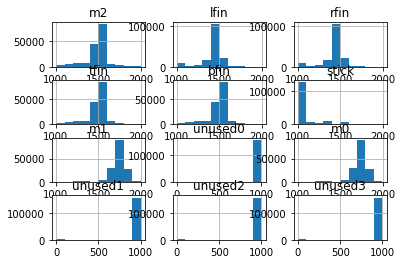

In [7]:
cur_act, cur_obs = objTrans.get_cur_transitions()
cur_act.hist()

array([[<AxesSubplot:title={'center':'imu.orientation.x'}>,
        <AxesSubplot:title={'center':'imu.orientation.y'}>,
        <AxesSubplot:title={'center':'imu.orientation.z'}>,
        <AxesSubplot:title={'center':'imu.orientation.w'}>],
       [<AxesSubplot:title={'center':'imu.angular_velocity.x'}>,
        <AxesSubplot:title={'center':'imu.angular_velocity.y'}>,
        <AxesSubplot:title={'center':'imu.angular_velocity.z'}>,
        <AxesSubplot:title={'center':'imu.linear_acceleration.x'}>],
       [<AxesSubplot:title={'center':'imu.linear_acceleration.y'}>,
        <AxesSubplot:title={'center':'imu.linear_acceleration.z'}>,
        <AxesSubplot:title={'center':'velocity.linear.x'}>,
        <AxesSubplot:title={'center':'velocity.linear.y'}>],
       [<AxesSubplot:title={'center':'velocity.linear.z'}>,
        <AxesSubplot:title={'center':'target.velocity.x'}>,
        <AxesSubplot:title={'center':'target.velocity.y'}>,
        <AxesSubplot:title={'center':'target.velocity.z'}>

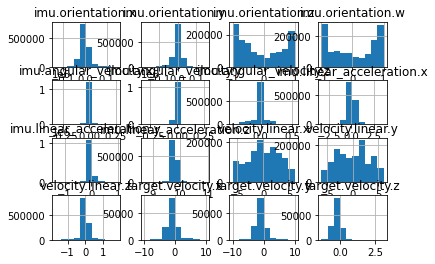

In [8]:
cur_obs.hist()

### Data processing

In [9]:
class Data_processing:
    def __init__(self):
        pass
        
    def fill_df_NA(self, df):
        df = df.fillna(method='ffill')
        df = df.fillna(0)
        return df
    
    # *******************************************
    def clean_error_data(self, df, act_scale_bnd, target_feature_list, **params):
        df = self.change_targetVelocity_frame_NED2ENU(df, target_feature_list)
        df = self.clean_act_error_row(df, act_scale_bnd)
        return df
    
    def clean_act_error_row(self, df, act_scale_bnd):
        act_min = act_scale_bnd['act_min']
        act_max = act_scale_bnd['act_max']
        df = self.clip_df(df, act_min, act_max, act_filter_feature)
        return df
    
    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[ df[filter_feature] >= df_min ]
            df = df[ df[filter_feature] <= df_max ]
        df.reset_index(drop=True, inplace=True)
        return df
    
    def change_targetVelocity_frame_NED2ENU(self, df, target_feature_list):
        x = target_feature_list[0]
        y = target_feature_list[1]
        z = target_feature_list[2]
        df = df.rename(columns={x:y, y:x})
        df[z] = -df[z]
        return df
    
    # *******************************************
        
    def data_processsing(self, df, **params):
        df = self.scale_df_act(df, act_scale_bnd, act_filter_feature)
        
        if bool_addNoise:
            df = self.duplicate_Noise_df(df, num_noise_df, noise_level)
        
        if bool_round:
            df = self.round_df(df, rounding_factor)
            
        df = self.clip_scaled_df(df, act_scale_bnd, act_filter_feature)
        
        return df
    
    def scale_df_act(self, df, act_scale_bnd, act_filter_feature):
        act_max, act_min = act_scale_bnd['act_max'],  act_scale_bnd['act_min']
        scaled_act_max, scaled_act_min = act_scale_bnd['scaled_act_max'], act_scale_bnd['scaled_act_min']
        
        act = df[ act_filter_feature ]
        act = self.minmax_scale_df(act, act_max, act_min, scaled_act_max, scaled_act_min)
        df[ act_filter_feature ] = act
        return df
    
    def minmax_scale_df(self, df, df_max, df_min, target_max, target_min):
        df_mean = ( df_max + df_min) / 2 
        target_mean = ( target_max + target_min ) / 2
        
        scale = ( df_max - df_min ) / (target_max - target_min) 
        df = ( df - df_mean ) / scale + target_mean
        return df
    
    def duplicate_Noise_df(self, df, num_noise_df, noise_level):
        new_df = df
        for i in range(num_noise_df):
            noised_df = self.addNoise_df(df, noise_level)
            new_df = pd.concat([new_df, noised_df], axis=0, ignore_index=True)
                    
        return new_df
    
    def addNoise_df(self, df, noise_level):
        df_range = df.max() - df.min()
        df_noise_range = noise_level * df_range / 2
        noise = np.random.uniform(-df_noise_range, df_noise_range, df.shape)
        df = df + noise
        return df
    
    def round_df(self, df, rounding_factor):
        new_df = df.round(rounding_factor)
        return new_df
    
    def clip_scaled_df(self, df, act_scale_bnd, act_filter_feature):
        scaled_act_min, scaled_act_max = act_scale_bnd['scaled_act_min'], act_scale_bnd['scaled_act_max']
        new_df = self.clip_df(df, scaled_act_min, scaled_act_max, act_filter_feature)
        return new_df

    # *******************************************

    def split_trainTest_df(self, df, train_test_split_ratio, **params):
        df_len = len(df.index)
        idx = self.get_trainTest_index(df_len, train_test_split_ratio)
        df_train, df_test = self.split_df(df, idx)
        return df_train, df_test
        
    def split_df(self, df, idx):
        idx_train, idx_test = idx
        df_train, df_test = df.loc[idx_train], df.loc[idx_test]
        df_train=df_train.reset_index(drop=True)
        df_test=df_test.reset_index(drop=True)
        return df_train, df_test
    
    def get_trainTest_index(self, n_data, ratio):
        ratio_train, ratio_test = ratio
        n_train = int(n_data*ratio_train)
        n_test = n_data - n_train 

        idx_randperm = np.random.permutation(n_data-1)
        idx_train = np.sort(idx_randperm[:n_train])
        idx_test = np.sort(idx_randperm[n_train+1:])
        return (idx_train, idx_test)
    
    # *******************************************

    def main(self, objTrans, **params):
        df = objTrans.df
        
        print("[ Data processing ] Fill NA ")
        df = self.fill_df_NA(df)
        
        print("[ Data processing ] Clean Error Data")
        df = self.clean_error_data(df, **params)
        
        print("[ Data processing ] Scale action data, Add noise, Round data, clip data ")
        df = self.data_processsing(df, **params)

        print("[ Data processing ] Split train and test data ")
        df_train, df_test = self.split_trainTest_df(df, **params)
        
        print('[ Data processing ] Complete')
        objTrans_train, objTrans_test = objTransitions(df_train, **params), objTransitions(df_test, **params)
        return objTrans_train, objTrans_test
        

In [10]:
clsDataProcessing = Data_processing()
objTrans_train, objTrans_test = clsDataProcessing.main(objTrans, **params)

[ Data processing ] Fill NA 
[ Data processing ] Clean Error Data
[ Data processing ] Scale action data, Add noise, Round data, clip data 
[ Data processing ] Split train and test data 
[ Data processing ] Complete


array([[<AxesSubplot:title={'center':'m2'}>,
        <AxesSubplot:title={'center':'lfin'}>,
        <AxesSubplot:title={'center':'rfin'}>],
       [<AxesSubplot:title={'center':'tfin'}>,
        <AxesSubplot:title={'center':'bfin'}>,
        <AxesSubplot:title={'center':'stick'}>],
       [<AxesSubplot:title={'center':'m1'}>,
        <AxesSubplot:title={'center':'unused0'}>,
        <AxesSubplot:title={'center':'m0'}>],
       [<AxesSubplot:title={'center':'unused1'}>,
        <AxesSubplot:title={'center':'unused2'}>,
        <AxesSubplot:title={'center':'unused3'}>]], dtype=object)

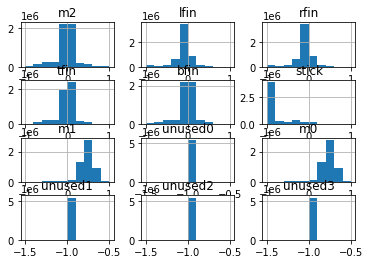

In [11]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_act.hist()

array([[<AxesSubplot:title={'center':'imu.orientation.x'}>,
        <AxesSubplot:title={'center':'imu.orientation.y'}>,
        <AxesSubplot:title={'center':'imu.orientation.z'}>,
        <AxesSubplot:title={'center':'imu.orientation.w'}>],
       [<AxesSubplot:title={'center':'imu.angular_velocity.x'}>,
        <AxesSubplot:title={'center':'imu.angular_velocity.y'}>,
        <AxesSubplot:title={'center':'imu.angular_velocity.z'}>,
        <AxesSubplot:title={'center':'imu.linear_acceleration.x'}>],
       [<AxesSubplot:title={'center':'imu.linear_acceleration.y'}>,
        <AxesSubplot:title={'center':'imu.linear_acceleration.z'}>,
        <AxesSubplot:title={'center':'velocity.linear.x'}>,
        <AxesSubplot:title={'center':'velocity.linear.y'}>],
       [<AxesSubplot:title={'center':'velocity.linear.z'}>,
        <AxesSubplot:title={'center':'target.velocity.x'}>,
        <AxesSubplot:title={'center':'target.velocity.y'}>,
        <AxesSubplot:title={'center':'target.velocity.z'}>

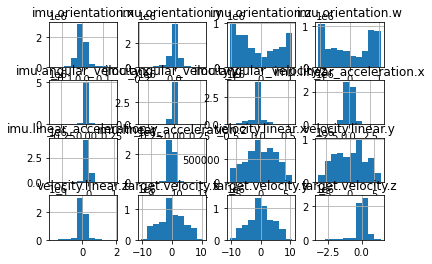

In [12]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.hist()

### Define Reward Function

In [14]:
class Define_rewardFn():
    def __init__(self):
        pass
 
    def reward_fn(self, next_obs_df, prev_act_list, prev_obs_list,
                  obs_reward_weights=(1,1), reward_weights=(1,0,1,1),
                  **params):
        
        next_obsCost_np = 0
        next_obsCost_np = self.calculate_obsCost(next_obs_df, obs_reward_weights, **params)

        prev_obsCost_np = 0
        for obs_df in prev_obs_list:
            obsCost_np = self.calculate_obsCost(obs_df, obs_reward_weights, **params)
            prev_obsCost_np += obsCost_np
        
        prev_actCost_np = 0
        for act_df in prev_act_list:
            actCost_np = self.calculate_actCost(act_df, actCost_feature_list)
            prev_actCost_np += actCost_np
        
        prev_actChangeCost_np = 0
        for i in range(len(prev_act_list)-1):
            act_df, next_act_df = prev_act_list[i], prev_act_list[i+1]
            actChangeCost_np = self.calculate_actChangeCost(act_df, next_act_df, actChangeCost_feature_list)
            prev_actChangeCost_np += actChangeCost_np

        rewards = reward_weights[0]*next_obsCost_np \
                    + reward_weights[1]*prev_obsCost_np \
                    + reward_weights[2]*prev_actCost_np \
                    + reward_weights[3]*prev_actChangeCost_np
        
        rewards = pd.DataFrame({'rewards':rewards})
        info = pd.DataFrame({'next_obsCost':next_obsCost_np, 'prev_obsCost':prev_obsCost_np, 
                             'prev_actCost':prev_actCost_np, 'prev_actChangeCost':prev_actChangeCost_np})
        return rewards, info
    
    def calculate_obsCost(self, obs_df, obs_reward_weights, **params):
        xy_target_df = obs_df[ xy_target_feature_list ]
        xy_cost_df = obs_df[ xy_cost_feature_list ]
        z_target_df = obs_df[ z_target_feature_list ]
        z_cost_df = obs_df[ z_cost_feature_list ]
        xyCost_np = obs_reward_weights[0]*self.calculate_xyCost(xy_cost_df, xy_target_df)
        zCost_np = obs_reward_weights[1]*self.calculate_zCost(z_cost_df, z_target_df)
        obs_cost_np = xyCost_np + zCost_np
        return obs_cost_np
    
    def calculate_xyCost(self, xy_df, xy_target_df):
        xyCost_np = xy_target_df.to_numpy()  - xy_df.to_numpy() 
        xyCost_np = -np.linalg.norm(xyCost_np, axis=1)
        return xyCost_np
    
    def calculate_zCost(self, z_df, z_target_df):
        zCost_np = z_target_df.to_numpy()  - z_df.to_numpy() 
        zCost_np = -np.abs(zCost_np).reshape(zCost_np.shape[0],)
        return zCost_np

    def calculate_actCost(self, act_df, actCost_feature_list):
        actCost_np = act_df[ actCost_feature_list ].to_numpy()
        actCost_np = -np.linalg.norm(actCost_np, axis=1) 
        return actCost_np
    
    def calculate_actChangeCost(self, act_df, next_act_df, actChangeCost_feature_list):
        actChangeCost_np = next_act_df[ actChangeCost_feature_list ].to_numpy() - act_df[ actChangeCost_feature_list ].to_numpy()
        actChangeCost_np = -np.linalg.norm(actChangeCost_np, axis=1) 
        return actChangeCost_np
    
    def split_xy(self, prev_act_list, prev_obs_list, next_obs, rewards):
        x_df_list = []
        for obs_df, act_df in zip(prev_obs_list, prev_act_list):
            obs_act_df = pd.concat([obs_df, act_df], axis=1)
            x_df_list.append(obs_act_df)
        x = pd.concat(x_df_list, axis=1)
        y = pd.concat([rewards, next_obs], axis=1)
        return x, y
        
    def main(self, objTrans, **params):
        prev_act_list, prev_obs_list = objTrans.get_prev_transitions_list()
        next_act, next_obs = objTrans.get_next_transitions()
                
        rewards, info = self.reward_fn(next_obs, prev_act_list, prev_obs_list, **params)
        x, y = self.split_xy(prev_act_list, prev_obs_list, next_obs, rewards)
        
        return x, y, rewards, info


In [48]:
clsDefineRewardFn = Define_rewardFn()
x_train, y_train, rewards_train, info_train = clsDefineRewardFn.main(objTrans_train, **params)
x_test, y_test, rewards_test, info_test = clsDefineRewardFn.main(objTrans_test, **params)

In [51]:
x_train

,imu.orientation.x,imu.orientation.y,imu.orientation.z,imu.orientation.w,imu.angular_velocity.x,imu.angular_velocity.y,imu.angular_velocity.z,imu.linear_acceleration.x,imu.linear_acceleration.y,imu.linear_acceleration.z,...,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,-0.035012,-0.003809,0.863032,0.503921,0.002371,0.066249,0.101069,-0.535885,-0.034170,9.596087,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
1,-0.035152,-0.003712,0.863152,0.503705,0.002365,0.066158,0.100458,-0.539287,-0.044875,9.595991,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
2,-0.035292,-0.003614,0.863273,0.503488,0.002294,0.066062,0.100717,-0.542662,-0.034148,9.595879,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
3,-0.035432,-0.003517,0.863394,0.503273,0.002291,0.065963,0.100123,-0.546050,-0.044860,9.595754,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
4,-0.035571,-0.003420,0.863514,0.503057,0.002223,0.065869,0.100394,-0.549414,-0.034183,9.595612,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430940,-0.014231,-0.005075,-1.022968,-0.193677,-0.000568,-0.028689,-0.002529,0.368383,0.054680,9.899392,...,0.413638,-0.192499,-0.186749,0.405603,-0.346307,-1.0,-0.331670,-1.0,-1.0,-1.0
5430941,-0.009047,0.006726,-0.939398,-0.193550,-0.012016,-0.034779,-0.026539,0.111136,0.020411,9.912864,...,0.373199,-0.200460,-0.129462,0.360986,-0.322767,-1.0,-0.294899,-1.0,-1.0,-1.0
5430942,-0.010185,-0.003385,-1.026848,-0.166355,-0.000792,-0.022082,-0.028132,0.289626,-0.004147,9.848739,...,0.373652,-0.176864,-0.111960,0.417953,-0.345440,-1.0,-0.295472,-1.0,-1.0,-1.0
5430943,-0.016039,-0.004749,-0.972950,-0.176077,0.012606,-0.019060,-0.004384,0.419851,0.051985,9.873769,...,0.364246,-0.183636,-0.143011,0.425262,-0.297970,-1.0,-0.380498,-1.0,-1.0,-1.0


array([[<AxesSubplot:title={'center':'next_obsCost'}>,
        <AxesSubplot:title={'center':'prev_obsCost'}>],
       [<AxesSubplot:title={'center':'prev_actCost'}>,
        <AxesSubplot:title={'center':'prev_actChangeCost'}>]],
      dtype=object)

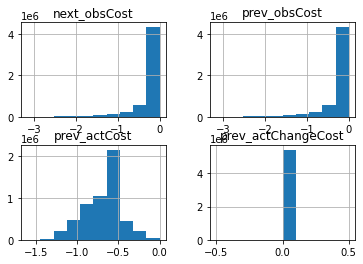

In [49]:
info_train.hist()

array([[<AxesSubplot:title={'center':'rewards'}>]], dtype=object)

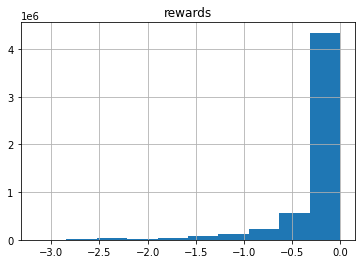

In [50]:
rewards_train.hist()

### Save data to csv

In [52]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.to_csv(os.path.join(results_path,'obs'), index=False)
cur_act.to_csv(os.path.join(results_path,'act'), index=False)
x_train.to_csv(os.path.join(results_path,'x_train'), index=False)
y_train.to_csv(os.path.join(results_path,'y_train'), index=False)
x_test.to_csv(os.path.join(results_path,'x_test'), index=False)
y_test.to_csv(os.path.join(results_path,'y_test'), index=False)

In [53]:
act_read_test = pd.read_csv(os.path.join(results_path,'act'))
obs_read_test = pd.read_csv(os.path.join(results_path,'obs'))

In [54]:
obs_read_test

,imu.orientation.x,imu.orientation.y,imu.orientation.z,imu.orientation.w,imu.angular_velocity.x,imu.angular_velocity.y,imu.angular_velocity.z,imu.linear_acceleration.x,imu.linear_acceleration.y,imu.linear_acceleration.z,velocity.linear.x,velocity.linear.y,velocity.linear.z,target.velocity.x,target.velocity.y,target.velocity.z
0,-0.035012,-0.003809,0.863032,0.503921,0.002371,0.066249,0.101069,-0.535885,-0.034170,9.596087,-1.288976,3.134487,0.105502,0.000000,0.000000,-0.000000
1,-0.035152,-0.003712,0.863152,0.503705,0.002365,0.066158,0.100458,-0.539287,-0.044875,9.595991,-1.291029,3.133432,0.104293,0.000000,0.000000,-0.000000
2,-0.035292,-0.003614,0.863273,0.503488,0.002294,0.066062,0.100717,-0.542662,-0.034148,9.595879,-1.292942,3.132503,0.103093,0.000000,0.000000,-0.000000
3,-0.035432,-0.003517,0.863394,0.503273,0.002291,0.065963,0.100123,-0.546050,-0.044860,9.595754,-1.294844,3.131557,0.101892,0.000000,0.000000,-0.000000
4,-0.035571,-0.003420,0.863514,0.503057,0.002223,0.065869,0.100394,-0.549414,-0.034183,9.595612,-1.296753,3.130596,0.100690,0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430940,-0.014231,-0.005075,-1.022968,-0.193677,-0.000568,-0.028689,-0.002529,0.368383,0.054680,9.899392,-0.960591,0.393377,-0.489647,-1.314285,-2.077066,0.495523
5430941,-0.009047,0.006726,-0.939398,-0.193550,-0.012016,-0.034779,-0.026539,0.111136,0.020411,9.912864,-0.718729,0.471425,-0.552305,-0.873777,-0.449335,0.292941
5430942,-0.010185,-0.003385,-1.026848,-0.166355,-0.000792,-0.022082,-0.028132,0.289626,-0.004147,9.848739,-1.096886,0.251660,-0.407001,-1.371341,-2.777571,0.125187
5430943,-0.016039,-0.004749,-0.972950,-0.176077,0.012606,-0.019060,-0.004384,0.419851,0.051985,9.873769,-1.212013,0.304317,-0.460862,-1.512963,-2.777216,0.220027


In [55]:
act_read_test

,m2,lfin,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,0.164000,-0.850000,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
1,0.164000,-0.850000,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
2,0.164000,-0.850000,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
3,0.164000,-0.850000,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
4,0.164000,-0.850000,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5430940,-0.125101,0.400748,0.413638,-0.192499,-0.186749,0.405603,-0.346307,-1.0,-0.331670,-1.0,-1.0,-1.0
5430941,-0.127848,0.453229,0.373199,-0.200460,-0.129462,0.360986,-0.322767,-1.0,-0.294899,-1.0,-1.0,-1.0
5430942,-0.168982,0.454623,0.373652,-0.176864,-0.111960,0.417953,-0.345440,-1.0,-0.295472,-1.0,-1.0,-1.0
5430943,-0.152142,0.369593,0.364246,-0.183636,-0.143011,0.425262,-0.297970,-1.0,-0.380498,-1.0,-1.0,-1.0


In [56]:
x_train

,imu.orientation.x,imu.orientation.y,imu.orientation.z,imu.orientation.w,imu.angular_velocity.x,imu.angular_velocity.y,imu.angular_velocity.z,imu.linear_acceleration.x,imu.linear_acceleration.y,imu.linear_acceleration.z,...,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,-0.035012,-0.003809,0.863032,0.503921,0.002371,0.066249,0.101069,-0.535885,-0.034170,9.596087,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
1,-0.035152,-0.003712,0.863152,0.503705,0.002365,0.066158,0.100458,-0.539287,-0.044875,9.595991,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
2,-0.035292,-0.003614,0.863273,0.503488,0.002294,0.066062,0.100717,-0.542662,-0.034148,9.595879,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
3,-0.035432,-0.003517,0.863394,0.503273,0.002291,0.065963,0.100123,-0.546050,-0.044860,9.595754,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
4,-0.035571,-0.003420,0.863514,0.503057,0.002223,0.065869,0.100394,-0.549414,-0.034183,9.595612,...,-0.850000,0.164000,0.164000,-0.992000,0.458000,-1.0,0.458000,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430940,-0.014231,-0.005075,-1.022968,-0.193677,-0.000568,-0.028689,-0.002529,0.368383,0.054680,9.899392,...,0.413638,-0.192499,-0.186749,0.405603,-0.346307,-1.0,-0.331670,-1.0,-1.0,-1.0
5430941,-0.009047,0.006726,-0.939398,-0.193550,-0.012016,-0.034779,-0.026539,0.111136,0.020411,9.912864,...,0.373199,-0.200460,-0.129462,0.360986,-0.322767,-1.0,-0.294899,-1.0,-1.0,-1.0
5430942,-0.010185,-0.003385,-1.026848,-0.166355,-0.000792,-0.022082,-0.028132,0.289626,-0.004147,9.848739,...,0.373652,-0.176864,-0.111960,0.417953,-0.345440,-1.0,-0.295472,-1.0,-1.0,-1.0
5430943,-0.016039,-0.004749,-0.972950,-0.176077,0.012606,-0.019060,-0.004384,0.419851,0.051985,9.873769,...,0.364246,-0.183636,-0.143011,0.425262,-0.297970,-1.0,-0.380498,-1.0,-1.0,-1.0


In [57]:
x_train_read_test = pd.read_csv(os.path.join(results_path,'x_train'))
y_train_read_test = pd.read_csv(os.path.join(results_path,'y_train'))

In [64]:
x_train_read_test[x_train_read_test['target.velocity.z']==0].count()

imu.orientation.x            42
imu.orientation.y            42
imu.orientation.z            42
imu.orientation.w            42
imu.angular_velocity.x       42
imu.angular_velocity.y       42
imu.angular_velocity.z       42
imu.linear_acceleration.x    42
imu.linear_acceleration.y    42
imu.linear_acceleration.z    42
velocity.linear.x            42
velocity.linear.y            42
velocity.linear.z            42
target.velocity.x            42
target.velocity.y            42
target.velocity.z            42
m2                           42
lfin                         42
rfin                         42
tfin                         42
bfin                         42
stick                        42
m1                           42
unused0                      42
m0                           42
unused1                      42
unused2                      42
unused3                      42
dtype: int64

In [61]:
y_train_read_test[y_train_read_test['target.velocity.x']==0].count()

rewards                      41
imu.orientation.x            41
imu.orientation.y            41
imu.orientation.z            41
imu.orientation.w            41
imu.angular_velocity.x       41
imu.angular_velocity.y       41
imu.angular_velocity.z       41
imu.linear_acceleration.x    41
imu.linear_acceleration.y    41
imu.linear_acceleration.z    41
velocity.linear.x            41
velocity.linear.y            41
velocity.linear.z            41
target.velocity.x            41
target.velocity.y            41
target.velocity.z            41
dtype: int64